## **Mount data directory**

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colab Notebooks/')
os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks'

## **Load required Libraries**

In [ ]:
import os 
import re

import numpy as np
import seaborn as sns
# !pip install imutils
import imutils

from IPython.display import Image
import matplotlib.cm as cm
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import cv2
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D, BatchNormalization,  MaxPool2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def plot_history(history, desc = ''):
    
    fig = plt.figure(figsize = (18 , 6))
    
    if desc:
        plt.title('{}'.format(desc), fontsize = 16, y = -0.1)

    subplot = (1, 2, 1)
    fig.add_subplot(*subplot)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()
    
    subplot = (1, 2, 2)
    fig.add_subplot(*subplot)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]  
    
    return new_image

In [ ]:
main = 'chest_xray'
categ = ['train', 'test']
classes = ['NORMAL', 'PNEUMONIA']
# images = []
# labels = []

# for i in categ:
#     sub_path = os.path.join(main, i)
#     for j  in classes:
#         path = os.path.join(sub_path, j) 
#         temp = os.listdir(path)
#         for x in temp:
#           try:
#             addr = os.path.join(path, x)
#             img_arr = cv2.imread(addr, cv2.IMREAD_GRAYSCALE)
#             # img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
# #             img_arr = crop_brain_contour(img_arr, False)
#             img_arr = cv2.resize(img_arr, (IMGS, IMGS))
#             images.append(img_arr)
#             if j == 'PNEUMONIA':
#                 l = 1
#             else:
#                 l = 0
#             labels.append(l)
#           except Exception as e:
#                 print(e)

# images = np.array(images)
# labels = np.array(labels)

### load save resized data to avoid time of loading from default input folder
images = np.load('chest_xray/images.npy')
labels = np.load('chest_xray/labels.npy')

print(images.shape, labels.shape)

(5856, 256, 256, 3) (5856,)


In [ ]:
images, labels = shuffle(images, labels)

In [ ]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(images, labels, random_state = 42, test_size = .30)
x_valid, x_test, y_valid, y_test = tts(x_test, y_test, random_state = 42, test_size = .50)

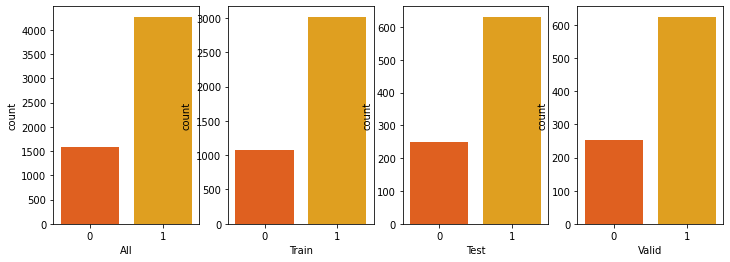

In [ ]:
# # Check data distribution in each category e.g. train, test, validation groups
fig = plt.figure(figsize = (12, 4))
plt.grid(True)
plt.axis(False)

fig.add_subplot(1, 4, 1)
sns.countplot(labels, palette = 'autumn')
plt.xlabel('All')

fig.add_subplot(1, 4, 2)
sns.countplot(y_train, palette = 'autumn')
plt.xlabel('Train')

fig.add_subplot(1, 4, 3)
sns.countplot(y_test, palette = 'autumn')
plt.xlabel('Test')

fig.add_subplot(1, 4, 4)
sns.countplot(y_valid, palette = 'autumn')
plt.xlabel('Valid')

plt.show()

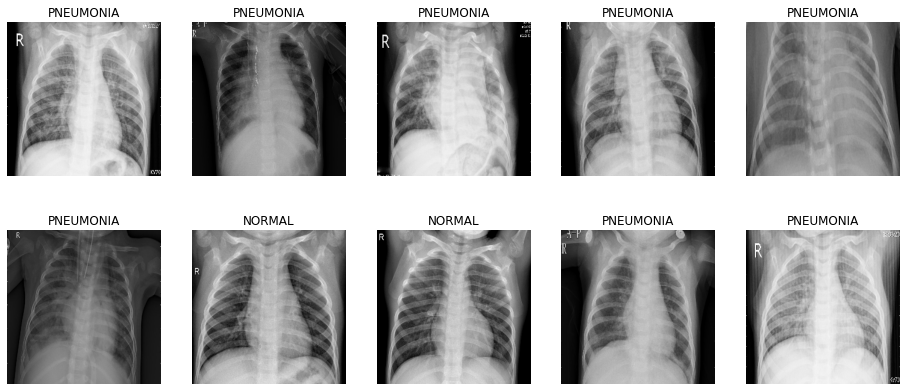

In [ ]:
# Visualize few loaded images
fig = plt.figure(figsize = (16,7))
z = np.random.randint(1, 5000, 11)
rows = 2
columns = 5
for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[z[i]])
    plt.title(classes[labels[z[i]]])
    plt.axis(False)
plt.show()

**Data Augmentation**

For the data augmentation, i choosed to :

Randomly rotate some training images by 30 degrees

1.   Randomly Zoom by 20% some training images
2.   Randomly shift images horizontally by 10% of the width
3.   Randomly shift images vertically by 10% of the height
4.   Randomly flip images horizontally. 

Once model is ready, we fit the training dataset.

In [ ]:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False, 
    # set each sample mean to 0 
    samplewise_center=False,  
     # divide inputs by std of the dataset
    featurewise_std_normalization=False, 
    # divide each input by its std
    samplewise_std_normalization=False,  
    # apply ZCA whitening
    zca_whitening=False, 
    # randomly rotate images in the range (degrees, 0 to 180) 
    rotation_range = 30, 
    # Randomly zoom image 
    zoom_range = 0.2, 
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,  
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,  
    # randomly flip images
    horizontal_flip = True,
    # randomly flip images  
    vertical_flip=False,
    # randomly shear images
    shear_range=0.2)  

# datagen.fit(x_train)

In [ ]:
IMGS = 256
x_train = x_train.reshape(-1, IMGS, IMGS, 3)
x_valid = x_valid.reshape(-1, IMGS, IMGS, 3)
x_test = x_test.reshape(-1, IMGS, IMGS, 3)

In [ ]:
# Rescale data
x_train = np.array(x_train, dtype='float') / 255.0
x_test  = np.array(x_test, dtype='float') / 255.0
x_valid = np.array(x_valid, dtype='float') / 255.0

In [ ]:
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('val_accuracy') > .95):
            print("Accuracy is High Enough so Stopping Training")
            self.model.stop_training= True

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

In [ ]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet' , include_top = False, 
                                         input_shape = (IMGS, IMGS, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
last = base_model.get_layer('block3_pool').output
x = layers.GlobalAveragePooling2D()(last)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation = 'relu')(x)
pred = layers.Dense(1, activation = 'sigmoid')(x)

In [ ]:
model = Model(base_model.input, pred)
model.compile(loss='binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(lr=0.001), 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
callback = my_callbacks()
history = model.fit(x_train, y_train, 
                    epochs = 12, 
                    batch_size = 32, 
                    validation_data = (x_valid, y_valid), 
                    callbacks = [callback])

model.save_weights('model.h5')  # always save your weights after training or during training

Epoch 1/12
129/129 [==============================] - 144s 785ms/step - loss: 10.4191 - accuracy: 0.7246 - val_loss: 0.4073 - val_accuracy: 0.7927
Epoch 2/12
129/129 [==============================] - 96s 741ms/step - loss: 0.3525 - accuracy: 0.8409 - val_loss: 0.3380 - val_accuracy: 0.8132
Epoch 3/12
129/129 [==============================] - 96s 741ms/step - loss: 0.3315 - accuracy: 0.8605 - val_loss: 0.2790 - val_accuracy: 0.8793
Epoch 4/12
129/129 [==============================] - 96s 742ms/step - loss: 0.2988 - accuracy: 0.8766 - val_loss: 0.2623 - val_accuracy: 0.8804
Epoch 5/12
129/129 [==============================] - 96s 742ms/step - loss: 0.2907 - accuracy: 0.8802 - val_loss: 0.3831 - val_accuracy: 0.7369
Epoch 6/12
129/129 [==============================] - 96s 741ms/step - loss: 0.2749 - accuracy: 0.8866 - val_loss: 0.2534 - val_accuracy: 0.8929
Epoch 7/12
129/129 [==============================] - 96s 743ms/step - loss: 0.2499 - accuracy: 0.8985 - val_loss: 0.2082 - val_

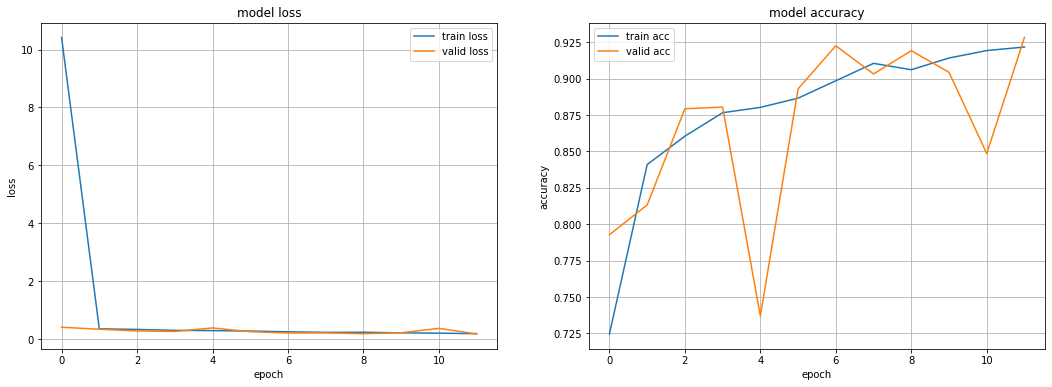

In [ ]:
# Accuracy and loss plots
plot_history(history)

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=16)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

55/55 [==============================] - 14s 180ms/step - loss: 0.1810 - accuracy: 0.9158
Test Loss =  0.1810411512851715
Test Accuracy =  0.9158134460449219


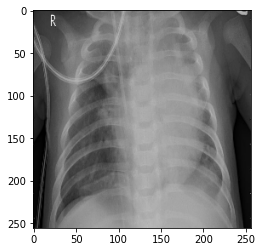

PNEUMONIA


In [ ]:
img_path = 'chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg'
img_arr = cv2.imread(img_path)
# img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
classes = ['NORMAL', 'PNEUMONIA']
img_arr = crop_brain_contour(img_arr, False)
img_arr = cv2.resize(img_arr, (IMGS, IMGS))
plt.imshow(img_arr)
plt.show()
img_arr = img_arr.reshape(1, IMGS, IMGS, 3)
print(classes[int(np.round(model.predict(img_arr)[0][0]))])

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.round(y_pred), y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86       278
         1.0       0.92      0.96      0.94       601

    accuracy                           0.92       879
   macro avg       0.91      0.89      0.90       879
weighted avg       0.92      0.92      0.91       879



In [ ]:
y_pred = np.round(y_pred)
y_pred = y_pred.reshape(-1,)
y_test = y_test.astype('float')

[‘True Neg’,’False Pos’
,’False Neg’,’True Pos’]


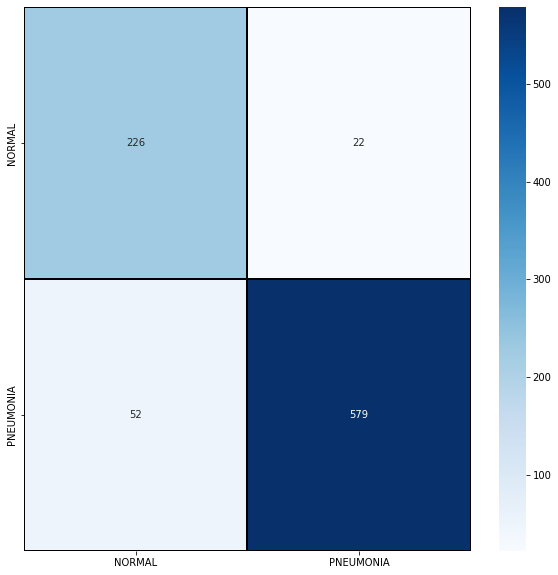

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='',xticklabels = classes, yticklabels = classes)
print('''[‘True Neg’,’False Pos’
,’False Neg’,’True Pos’]''')
plt.show()

In [ ]:
lay = []
for layer in model.layers:
    lay.append(layer.name)
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
global_average_pooling2d
dense
dropout
dense_1
dropout_1
dense_2
dense_3


In [ ]:
# Read Image as array
def get_img_array(img_path, size):
    img_arr = cv2.imread(img_path)
    img_arr = crop_brain_contour(img_arr, False)
    img_arr = cv2.resize(img_arr, (IMGS, IMGS))
    img_arr = img_arr.reshape(1, IMGS, IMGS, 3)
    return img_arr

In [ ]:
# Prepare for gradcam
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
img_path = 'chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg'

(1, 256, 256, 3)
Predicted: PNEUMONIA


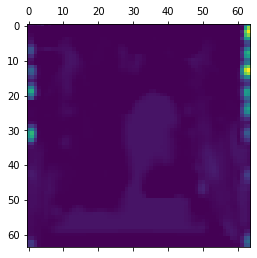

In [ ]:
img_array = get_img_array(img_path, size = img_size)
# NORMAL/IM-0147-0001.jpeg
print(img_array.shape)

# # Make model
# model = model_builder(weights="imagenet")
# # Print what the top predicted class is
preds = model.predict(img_array)
# print(preds)
print("Predicted:", classes[int(np.round(model.predict(img_arr)[0][0]))])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)
# Display heatmap
plt.matshow(heatmap)
plt.show()

Predicted: PNEUMONIA


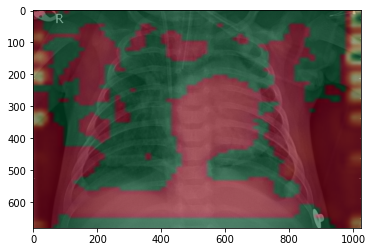

In [ ]:
# super imposed heatmap on original image
import tensorflow
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("RdYlGn_r")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tensorflow.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tensorflow.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.9 + img
superimposed_img = tensorflow.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "grad_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
print("Predicted:", classes[int(np.round(model.predict(img_arr)[0][0]))])
plt.imshow(superimposed_img)
plt.show()
# display(Image(save_path))